In [18]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings

In [2]:
pd.set_option('max_columns', 101)
sns.set_theme()


In [3]:
EXPERIMENT_ID = 7

In [4]:
BASE_DIR = fr'..\..\..\data\simulated_transactions_grid_dist_grid\experiment_{EXPERIMENT_ID}'
BASE_DIR

'..\\..\\..\\data\\simulated_transactions_grid_dist_grid\\experiment_7'

In [5]:
os.listdir(BASE_DIR)

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'config.txt']

In [6]:
X_NAME = 'X'
Y_NAME = 'Y'

TOKEN_0 = X_NAME
TOKEN_1 = Y_NAME
INITIAL_RESERVE = 30000

In [7]:
class Simulation:
    def __init__(self,):
        self.occ_min = None
        self.initial_reserve_usd = None
        self.ratio_sec_usd = None
        self.amount_in_std = None
        self.amount_in_Y_std = None
      #  self.blo
    

In [8]:
def find_longest_blocked_sequence(s: pd.Series):
    cnt = 0
    max_cnt = 0
    
    for index, value in s.items():
        if value != 'SUCCESS':
            cnt += 1
        else:
            max_cnt = max(max_cnt, cnt)
            cnt = 0
    
    return max(max_cnt, cnt)

In [10]:
def remove_first_day(s: pd.Series):
    min_time = s.transaction_timestamp.min()
    seconds_day = (60*60*24)
    
    s = s[s.transaction_timestamp - min_time >= seconds_day]
    
    return s

In [11]:
def read_simulation_stats(folder):
    simulation = {}
    
    config_filename = os.path.join(folder, 'config.txt')
    swaps_filename = os.path.join(folder, 'swaps_normalized.csv')
    pool_state_filename = os.path.join(folder, 'pool_after_transaction_normalized.csv')
    
    with open(config_filename) as f:
        for line in f:
            line = line.rstrip('\n')
            
            param_key = line.split(':')[0]
            param_value = line.split(' ')[-1]
            
            simulation[param_key] = param_value
            
    pool_state_df = pd.read_csv(pool_state_filename)
    swaps_df = pd.read_csv(swaps_filename)
    
 #   simulation['id'] = simulation_id

    #print(swaps_filename)
    #print(swaps_df.shape)
    #print(swaps_df.status.value_counts())
    swaps_df = swaps_df[swaps_df.status != 'PENDING']
        
    simulation['count'] = swaps_df.shape[0]
    simulation['blocked_transactions'] = (swaps_df.status != 'SUCCESS').sum()
    simulation['blocked_transactions_pct'] = simulation['blocked_transactions']/len(swaps_df)

    simulation['blocked_by_volatility_mitigator'] = (swaps_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION').sum()
    simulation['blocked_by_volatility_mitigator_pct'] = simulation['blocked_by_volatility_mitigator'] / simulation['blocked_transactions']

    simulation['blocked_exceeded_slippage'] = (swaps_df.status == 'EXCEEDED_MAX_SLIPPAGE').sum()
    simulation['blocked_exceeded_slippage_pct'] = simulation['blocked_exceeded_slippage'] / simulation['blocked_transactions']
    
    simulation['blocked_not_enough_reserves'] = (swaps_df.status == 'NOT_ENOUGH_RESERVES').sum()
    simulation['blocked_not_enough_reserves_pct'] = simulation['blocked_not_enough_reserves'] / simulation['blocked_transactions']
    
    simulation['longest_blocked_sequence'] = find_longest_blocked_sequence(swaps_df.status)
    simulation['longest_blocked_sequence_pct'] = simulation['longest_blocked_sequence'] / len(swaps_df)
    
    simulation['blocked_k_error'] = (swaps_df.status == 'K_ERROR').sum()
    simulation['blocked_k_error_pct'] = simulation['blocked_k_error'] / simulation['blocked_transactions']
    
    simulation['amount_in_Y_std_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS'), 'token_in_amount'].std()
    simulation['max_X_in_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.max()
    simulation['max_Y_in_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.max()

    simulation['max_X_out_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.max()
    simulation['max_Y_out_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.max()
    
    
    simulation['mean_X_in_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.mean()
    simulation['mean_Y_in_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.mean()
    
    simulation['mean_X_out_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.mean()
    simulation['mean_Y_out_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.mean()
    
    
    simulation['price_X_std'] = (pool_state_df['reserve_Y'] / pool_state_df['reserve_X']).std()
    simulation['price_Y_std'] = (pool_state_df['reserve_X'] / pool_state_df['reserve_Y']).std()
    
    g = swaps_df.groupby(['token_in', 'status']).size()
    simulation['success_X_in_ratio'] = g.loc[(X_NAME, 'SUCCESS')] /  g.loc[(Y_NAME, 'SUCCESS')]
    
    simulation['shape'] = float(simulation['shape'])
    simulation['scale'] = float(simulation['scale'])
    simulation['initial_reserve_usd'] = float(simulation['initial_reserve_usd'])
    simulation['slippage'] = float(simulation['slippage'])
    
    return simulation

In [12]:
def read_config(config_filename):
    config = {}
    
    with open(config_filename) as f:
        for line in f:
            line = line.rstrip('\n')

            param_key = line.split(':')[0]
            param_value = line.split(' ')[-1]

            config[param_key] = param_value
            
    return config

In [13]:
def remove_initial_swaps(df, initial_time_seconds):
    min_time = df.transaction_timestamp.min() + initial_time_seconds
    
    return df[df.transaction_timestamp >= min_time]

In [14]:
import datetime

def _read_simulation(folder:str):
    pool_state_before_transactions_path = os.path.join(folder, 'pool_before_transaction_normalized.csv')
    pool_state_after_transactions_path = os.path.join(folder, 'pool_after_transaction_normalized.csv')
    swap_transactions_path = os.path.join(folder, 'swaps_normalized.csv')
    config_path = os.path.join(folder, 'config.txt')
        
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    config = read_config(config_path)
    stats = read_simulation_stats(folder)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)
    
    swaps_df = remove_initial_swaps(swaps_df, 24*60*60)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    #print('RS', swap_transactions_path)
    #print('RS', swaps_df.shape)
    
    return swaps_df, config, stats

In [15]:
def read_simulation_iter(folder):
    '''
    At each iteration 2 simulation are being performed: with volatility mitigation mechanism disabled and enabled
    '''
    sim0 = _read_simulation(os.path.join(folder, '0'), )
    sim1 = _read_simulation(os.path.join(folder, '1'))
    
    return sim0, sim1

In [20]:
simulations = []
config_list = []
stats_list = []

SUBINDEXES = 16

cnt = 0

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for i, subindex_id in enumerate(os.listdir(BASE_DIR)):
        if subindex_id.endswith('.txt') or subindex_id.endswith('.csv'): # todo: continue if any file
            continue

        subindex_path = os.path.join(BASE_DIR, subindex_id)

        for j, iteration_id in enumerate(os.listdir(subindex_path)):
            if iteration_id.endswith('.txt') or iteration_id.endswith('.csv'):
                continue

            sim_path = os.path.join(subindex_path, iteration_id)

           # print(sim_path)
            sim0, sim1 = read_simulation_iter(sim_path)


            sim0[2]['sim_index'] = i*11*2 + j*2
            sim1[2]['sim_index'] = i*11*2 + j*2 + 1

            simulations.extend([sim0[0], sim1[0]])
            config_list.extend([sim0[1], sim1[1]])
            stats_list.extend([sim0[2], sim1[2]])

In [21]:
config_df = pd.DataFrame.from_records(config_list)
stats_df = pd.DataFrame.from_records(stats_list)

In [22]:
filtered_stats_df = stats_df[(stats_df['volatility_mitigator'] == 'True') ].copy()
filtered_stats_off_df = stats_df[(stats_df['volatility_mitigator'] == 'False') ].copy()

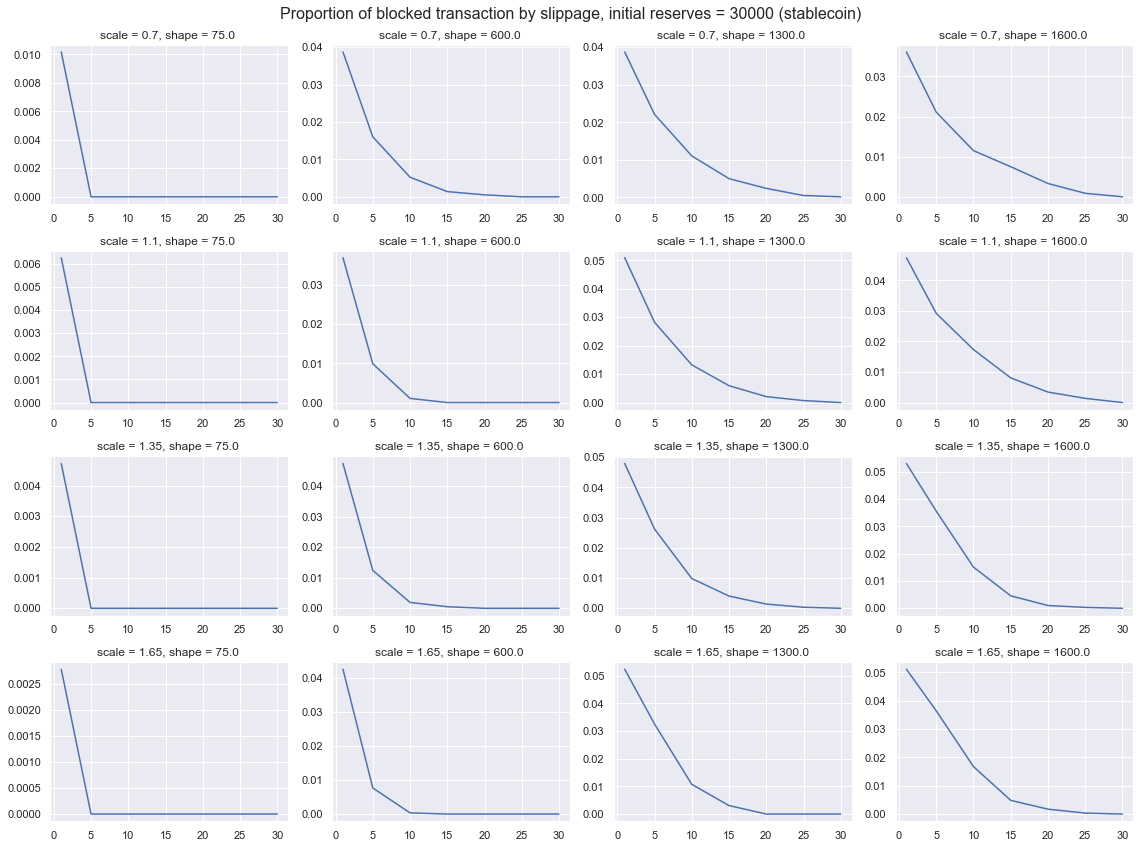

In [24]:
import matplotlib.pyplot as plt

filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)
groups = filtered_stats_df.groupby(['shape', 'scale'])

N = len(groups)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)
fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
ax = ax.ravel()

i = 0

for name, group_stats_df in groups:
    slippage_list = []
    blocks_list = []
    
    group_stats_df.sort_values('slippage', inplace=True)
    #print(group_stats_df)
    
    for index, row in group_stats_df.iterrows():      
        blocks = row['blocked_exceeded_slippage']
        total = row['count']
        
        blocks_list.append(blocks/total)
        slippage_list.append(row['slippage'])

        
    ax[i].plot(slippage_list, blocks_list)

    fig.suptitle(f'Proportion of blocked transaction by slippage, initial reserves = {INITIAL_RESERVE} (stablecoin)', fontsize=16)
    fig.tight_layout()
    
    ax[i].set_title(f'scale = {name[0]}, shape = {name[1]} ') #todo: iloc may differ from simulatuions df

    i += 1

    #print(name)
